![alt text](https://i.imgur.com/1WaY7aA.png)

# Data Science and AI
## Lab 6.1.1: K-Means by the algorithm

### Australian athletes data set

##### Description
These data were collected in a study of how data on various characteristics of the bloood varied with sport body size and sex of the athlete.

Usage
data(ais)
Format
A data frame with 202 observations on the following 13 variables.

rcc
red blood cell count, in

wcc
while blood cell count, in per liter

hc
hematocrit, percent

hg
hemaglobin concentration, in g per decaliter

ferr
plasma ferritins, ng

bmi
Body mass index, kg

ssf
sum of skin folds

pcBfat
percent Body fat

lbm
lean body mass, kg

ht
height, cm

wt
weight, kg

sex
a factor with levels f m

sport
a factor with levels B_Ball Field Gym Netball Row Swim T_400m T_Sprnt Tennis W_Polo

Details
Do blood hemoglobin concentrations of athletes in endurance-related events differ from those in power-related events?

Source
These data were the basis for the analyses that are reported in Telford and Cunningham (1991).

References
Telford, R.D. and Cunningham, R.B. 1991. Sex, sport and body-size dependency of hematology in highly trained athletes. Medicine and Science in Sports and Exercise 23: 788-794.

**References**

[Data](http://vincentarelbundock.github.io/Rdatasets/csv/DAAG/ais.csv)

[Data Dictionary](http://vincentarelbundock.github.io/Rdatasets/doc/DAAG/ais.html)

In [1]:
# IMPORT LIBRARIES
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from itertools import combinations
from scipy import stats

### 1. Import the data

In [34]:
csv_file = 'data/ais.csv'

In [35]:
data = pd.read_csv(csv_file)

In [36]:
data.head()

,Unnamed: 0,rcc,wcc,hc,hg,ferr,bmi,ssf,pcBfat,lbm,ht,wt,sex,sport
0,1,3.96,7.5,37.5,12.3,60,20.56,109.1,19.75,63.32,195.9,78.9,f,B_Ball
1,2,4.41,8.3,38.2,12.7,68,20.67,102.8,21.30,58.55,189.7,74.4,f,B_Ball
2,3,4.14,5.0,36.4,11.6,21,21.86,104.6,19.88,55.36,177.8,69.1,f,B_Ball
3,4,4.11,5.3,37.3,12.6,69,21.88,126.4,23.66,57.18,185.0,74.9,f,B_Ball
4,5,4.45,6.8,41.5,14.0,29,18.96,80.3,17.64,53.20,184.6,64.6,f,B_Ball


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 14 columns):
Unnamed: 0    202 non-null int64
rcc           202 non-null float64
wcc           202 non-null float64
hc            202 non-null float64
hg            202 non-null float64
ferr          202 non-null int64
bmi           202 non-null float64
ssf           202 non-null float64
pcBfat        202 non-null float64
lbm           202 non-null float64
ht            202 non-null float64
wt            202 non-null float64
sex           202 non-null object
sport         202 non-null object
dtypes: float64(10), int64(2), object(2)
memory usage: 22.2+ KB


### 2. Do some EDA of relationships between features.

In [38]:
def find_feature_correlations(df):
    
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    # initalise variable lists 
    var1 = []
    var2 = []
    pearsons = []
    
    # iterate over generator for tuples of feature combination pairs
    for comb in combinations(df.columns.tolist(), 2):
        
        v1 = comb[0] 
        var1.append(v1) # save feature 1 to list 

        v2 = comb[1]
        var2.append(v2) # save feature 2 to list
        
        p, _ = stats.pearsonr(df[v1], df[v2]) # get pearson correlation
        pearsons.append(p)
    
    # Build dataframe of feature1 vs. feature2 pearson correlation
    corr_df = pd.DataFrame({'Feature1': var1,
                            'Feature2': var2,
                            'P': pearsons})
    
    return corr_df

In [39]:
find_feature_correlations(data.select_dtypes(np.number))

,Feature1,Feature2,P
0,Unnamed: 0,rcc,0.658358
1,Unnamed: 0,wcc,0.153908
2,Unnamed: 0,hc,0.660805
3,Unnamed: 0,hg,0.689778
4,Unnamed: 0,ferr,0.441281
...,...,...,...
61,pcBfat,ht,-0.188022
62,pcBfat,wt,-0.000193
63,lbm,ht,0.802119
64,lbm,wt,0.930913


In [40]:
# See the correlations in descending order

corr = data.select_dtypes(np.number).corr() # df is the pandas dataframe
c1 = corr.abs().unstack()
c1 = pd.DataFrame(c1)
c1 = c1.reset_index()
c1.columns = ['Feature 1', 'Feature 2', 'P']
result_df = c1.drop_duplicates(subset=['Feature 1', 'Feature 2'], keep='first')
result_df

,Feature 1,Feature 2,P
0,Unnamed: 0,Unnamed: 0,1.000000
1,Unnamed: 0,rcc,0.658358
2,Unnamed: 0,wcc,0.153908
3,Unnamed: 0,hc,0.660805
4,Unnamed: 0,hg,0.689778
...,...,...,...
139,wt,ssf,0.154196
140,wt,pcBfat,0.000193
141,wt,lbm,0.930913
142,wt,ht,0.780932


### 3. Prepare the data for clustering

1. Remove the `sex`, `sport` column. We will see if the clusters from K-Means end up like the actual sex.
2. Put the features on the same scale.

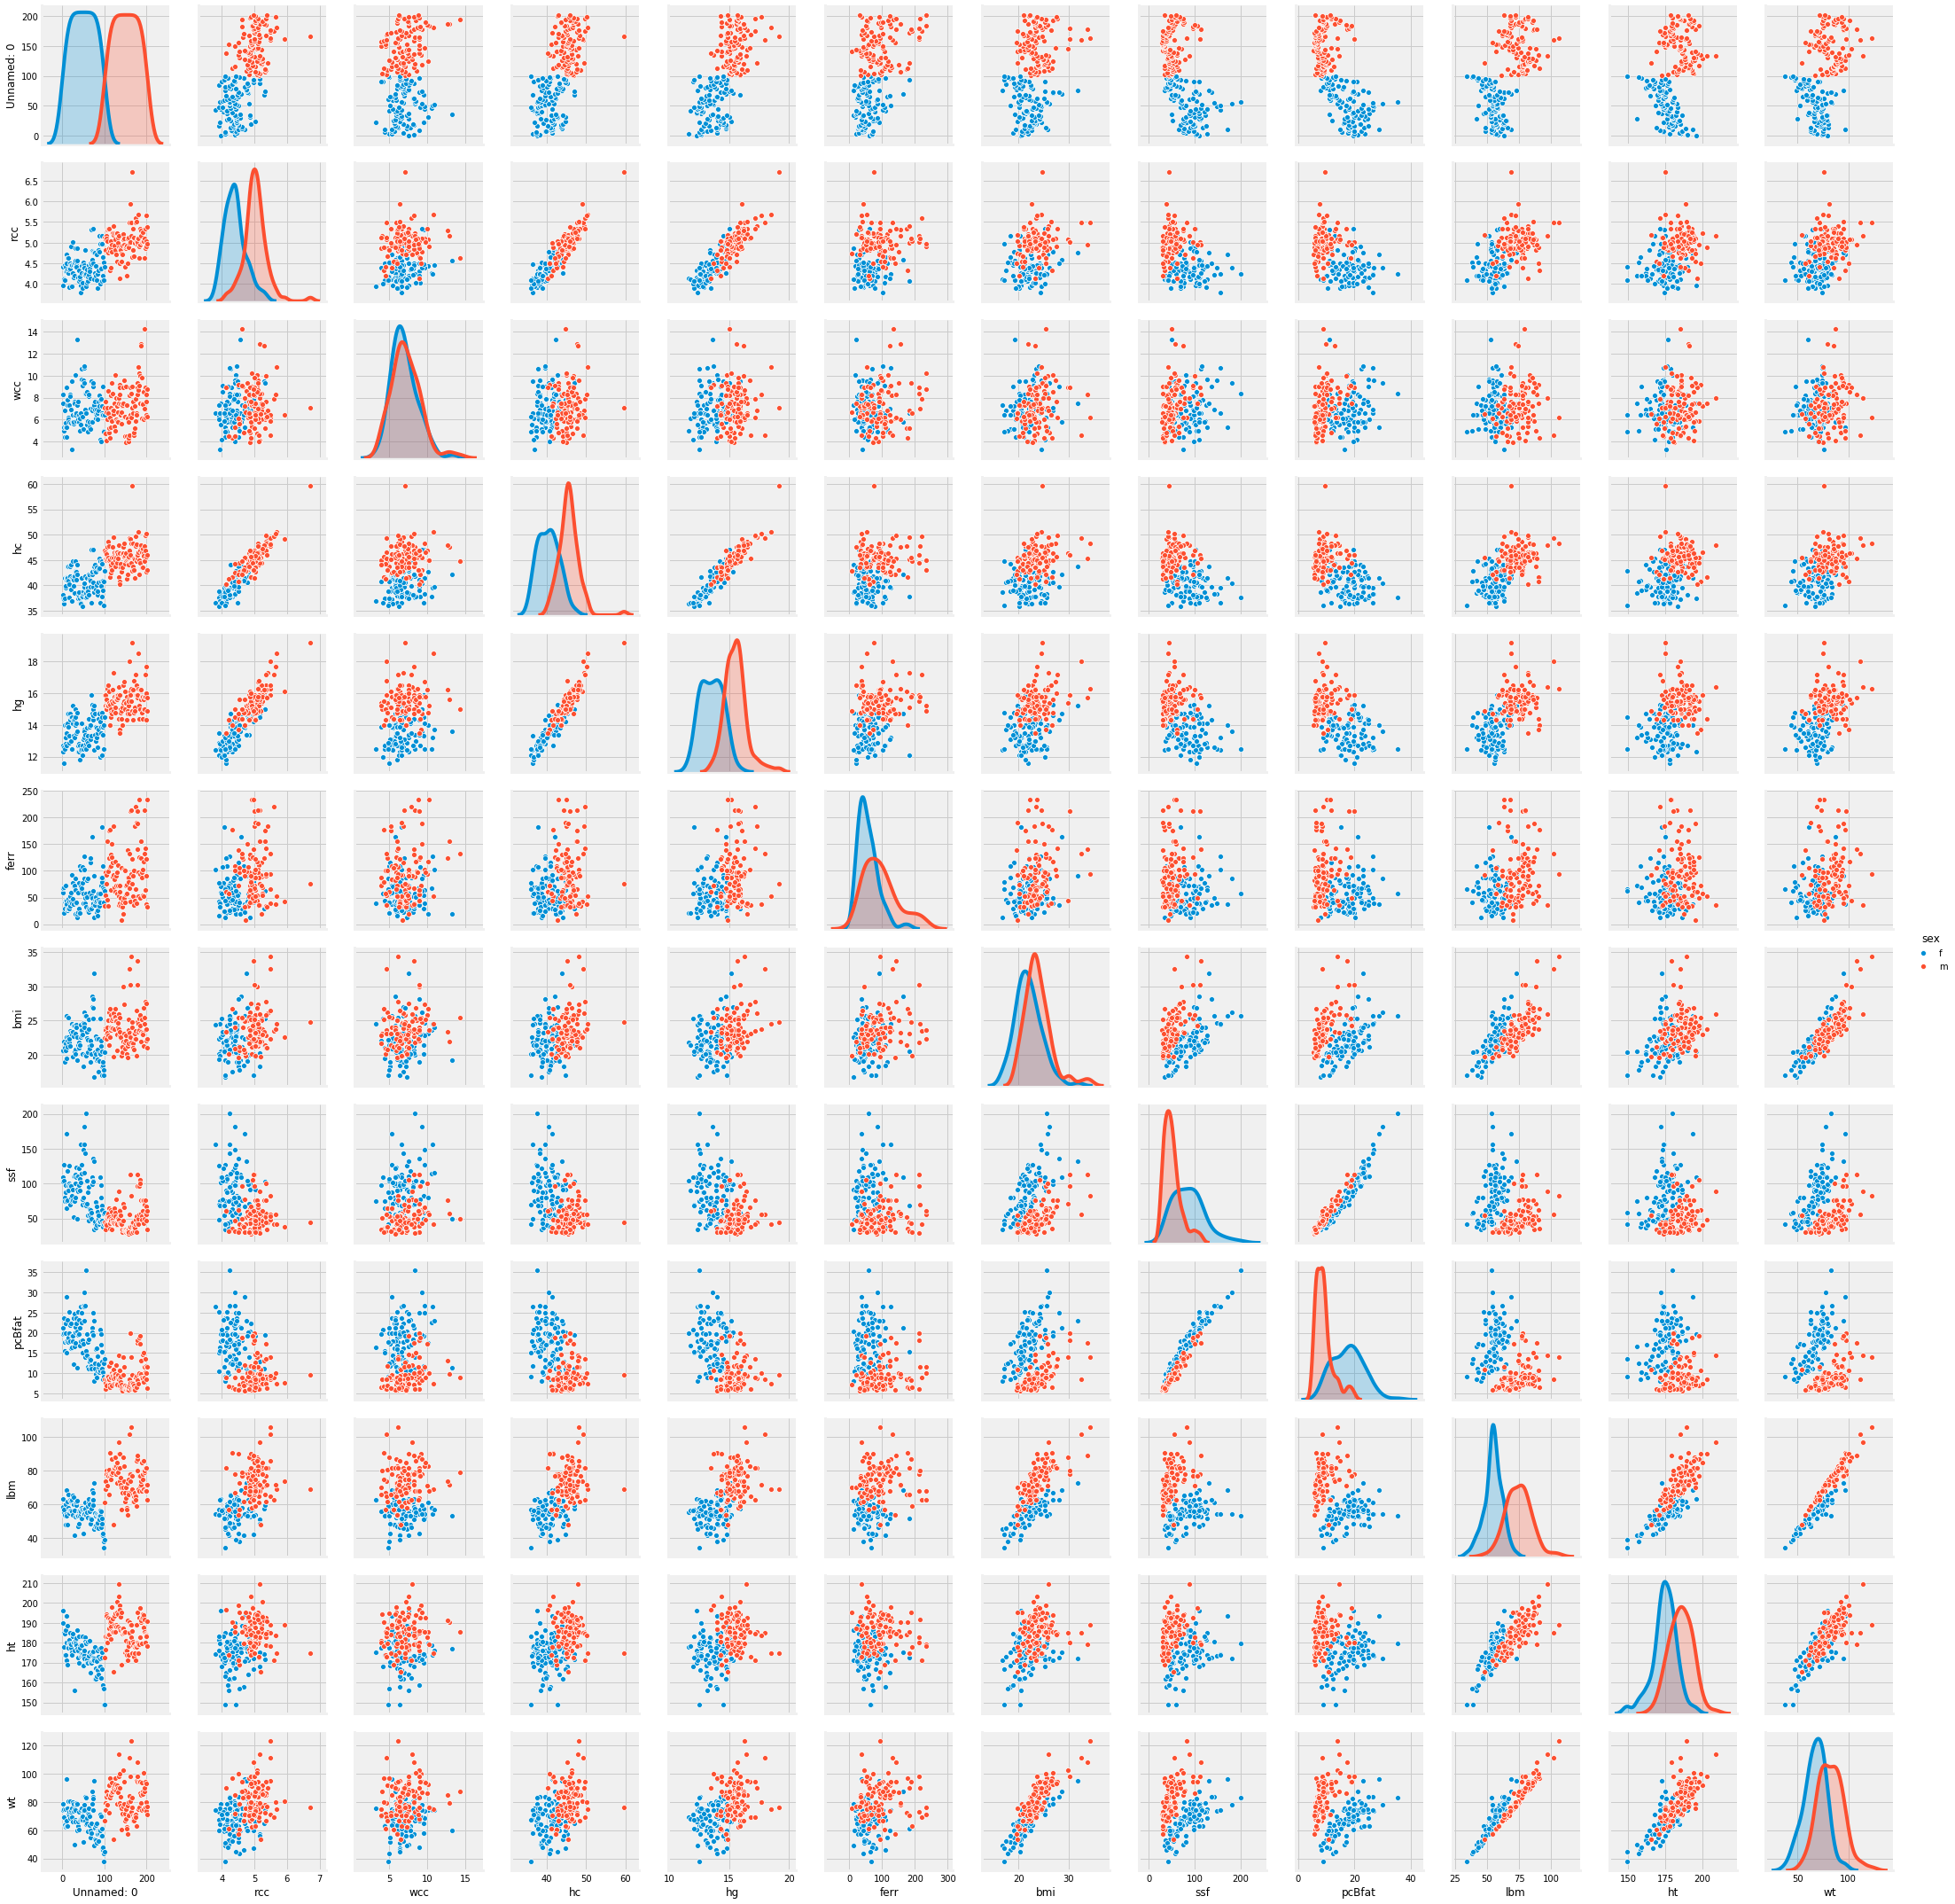

In [25]:
# ANSWER
sns.pairplot(data, hue='sex')
plt.show()

In [41]:
data['sex'].value_counts()

m    102
f    100
Name: sex, dtype: int64

In [44]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np

# Create scaler
scaler = preprocessing.StandardScaler()

X = data.drop(['sex','sport'],axis= 1)
Xs = scaler.fit_transform(X)

### 4. Clustering with K-Means

- Cluster the data to our our target groups.
    - Use sklearn.cluster.KMeans
- We know that there are 2 actual classes. Lets try using 2, 4. Run the clustering algorithm with each of those k values.

In [45]:
# ANSWER
k = 2
k_mean2 = KMeans(n_clusters=k)
k_mean2.fit(Xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### 5. Get the labels for the models

In [46]:
labels_2 = k_mean2.labels_
print(labels_2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### 6. Elbow Method For Optimal k

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre. As k increases, the sum of squared distance tends to zero. 

In [49]:
# ANSWER
sum_of_squared_distances = []

K = range (1,15)

for k in K:
    
    km=KMeans(n_clusters= k)
    
    km=km.fit(Xs)
    sum_of_squared_distances.append(km.inertia_)

Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

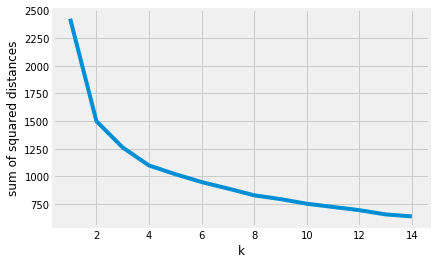

In [50]:
# ANSWER
plt.plot (K, sum_of_squared_distances)
plt.xlabel ('k')
plt.ylabel ('sum of squared distances')
plt.show()

### 7. Plot `ht` vs. `wt` using the clusters from each model.

- Plot ht, wt using hue sex
- Plot ht, wt using hue label

Each time, compare to the actual species classification.

AttributeError: 'Line2D' object has no property 'hue'

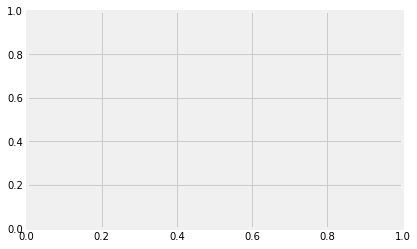

In [52]:
# ANSWER
plt.plot (data['ht'], data['wt'], hue ='sex')
plt.xlabel ('ht')
plt.ylabel ('wt')
plt.show()